In [94]:
!pip3 install texttable sklearn
%matplotlib notebook

In [95]:
import sys
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from texttable import Texttable
from sklearn.externals import joblib
from numpy import nan as nan

import numpy as np
import requests
from functional import seq
import os
import json
import calendar
import time
from sklearn.preprocessing import MinMaxScaler
import uuid

NORMALIZATION_SERVER = 200
# NORMALIZATION_COOLING = 20000
ADD_EXTERNAL_TEMPERATURE = False


def simulate_consumption_function(data):

    weight = [
        0.82, 0.85, 0.87, 0.90, 0.97, 0.99, 0.93, 0.82, 0.72, 0.70, 0.85, 0.98,
        0.82, 0.85, 0.87, 0.90, 0.97, 0.99, 0.93, 0.82, 0.72, 0.70, 0.78, 0.85,
        0.95, 0.94, 0.87, 0.90, 0.97, 0.99, 0.93, 0.82, 0.72, 0.70, 0.70, 0.68,
        0.97, 0.99, 0.87, 0.90, 0.97, 0.99, 0.93, 0.82, 0.72, 0.70, 0.70, 0.68,
    ]

    if len(data) < 10:
        raise Exception("Error: len(data) < 0")

    consumption = sum([x * y for (x, y) in zip(weight, data)])
    normalized_consumption = consumption / len(weight)

    # return math.sin(normalized_consumption)
    return normalized_consumption


def generate_fake_consumption_data(nb_servers, nb_data):
    x = np.random.random((nb_data, nb_servers))
    y = np.apply_along_axis(simulate_consumption_function, 1, x)
    return x, y


def cluster_average_temperature(start_epoch, end_epoch, side="back"):

    resp = requests.get("https://api.seduce.fr/infrastructure/description/tree")
    resp_json = resp.json()
    servers_names = list(resp_json.get("power").keys())

    back_temperature_sensors = [v.get(side) for v in resp_json.get("temperature").values() if v.get(side) is not None]

    server_sensors_list = []

    for back_temperature_sensor in back_temperature_sensors:
        sensors = [(s.get("tags")[0], s.get("serie")) for s in back_temperature_sensor.values() if s.get("tags")]

        server_sensors_list += sensors

    sorted_server_sensors_list = sorted(server_sensors_list, key=lambda x: int(x[0].split("-")[-1]))
    sorted_sensors = [x[1] for x in sorted_server_sensors_list]

    temperatures = []

    for sensor in sorted_sensors:
        temperature_url = "https://api.seduce.fr/sensors/%s/measurements?start_date=%s&end_date=%s" % (sensor, int(start_epoch), int(end_epoch))
        sensor_temperatures = requests.get(temperature_url).json().get("values")
        temperatures += [np.mean(sensor_temperatures)]
        print(".", end="")
    print("")

    return temperatures


def average_temperature_aggregated_by_minute(start_epoch, end_epoch, side="back"):
    temperature_url = "https://dashboard.seduce.fr/rack/%s/temperatures/aggregated?start_date=%ss&end_date=%ss" % (side, int(start_epoch), int(end_epoch))
    sensor_temperatures = requests.get(temperature_url).json()

    return sensor_temperatures


def generate_real_consumption_data(start_date=None,
                                   end_date=None,
                                   show_progress=True,
                                   data_file_path="data.json",
                                   group_by=60,
                                   scaler=None):

    if start_date is None:
        # start_date = "2019-05-24T08:00:00.000Z"
        start_date = "2019-06-01T06:00:00.000Z"
        # start_date = "2019-07-07T06:00:00.000Z"
    if end_date is None:
        # end_date = "2019-06-11T08:00:00.000Z"
        end_date = "2019-07-08T09:09:35.000Z"

    # Group node data every 120 minutes
    # group_by = 60
    # group_by = 35
    # group_by = 2 * 60

    seduce_infrastructure_tree = requests.get("https://api.seduce.fr/infrastructure/description/tree").json()

    power_infrastructure_tree = requests.get("https://api.seduce.fr/power_infrastructure/description/tree").json()
    # servers_names_raw = power_infrastructure_tree['children'][0]['children'][1]['children'][1]['node'].get("children")
    # servers_names_raw = [f"ecotype-{i}" for i in range(25, 37)]
    servers_names_raw = [f"ecotype-{i}" for i in range(37, 49)]
    # servers_names_raw = sorted(servers_names_raw, key=lambda x: int(x.split("-")[1]))

    servers_names = seq(servers_names_raw)
    # servers_names = servers_names.take(2)

    # nodes_names = servers_names[:1] + ["back_temperature"]
    # nodes_names = servers_names

    reload_data = False
    # reload_data = True
    if not os.path.exists(data_file_path):
        reload_data = True
    else:
        with open(data_file_path, "r") as data_file:
            data = json.load(data_file)
            if data.get("start_date") != start_date or data.get("end_date") != end_date or data.get("group_by") != group_by:
                reload_data = True

    if reload_data:

        data = {
            "consumptions": {},
            "start_date": start_date,
            "end_date": end_date,
            "group_by": group_by,
            "room_temperature": [],
            "min_consumption": None,
            "max_consumption": None,
            "min_temperature": None,
            "max_temperature": None
        }

        epoch_times = [calendar.timegm(time.strptime(t, '%Y-%m-%dT%H:%M:%S.000Z')) for t in [start_date, end_date]]
        start_epoch = min(epoch_times)
        end_epoch = max(epoch_times)

        group_by_seconds = "%ss" % (group_by * 60)
        dump_data_url = """https://dashboard.seduce.fr/dump/all/aggregated?start_date=%ss&end_date=%ss&group_by=%s""" % (start_epoch, end_epoch, group_by_seconds)
        dump_data = requests.get(dump_data_url).json()

        incomplete_series = [v
                             for v in dump_data["sensors_data"].values()
                             if len(v.get("timestamps", [])) != max([len(v1.get("timestamps"))
                                                                     for v1 in dump_data["sensors_data"].values()
                                                                     ])
                             ]

        if len(incomplete_series) > 0:
            raise("Some series are incomplete!")

        data["timestamps"] = list(set([ts
                                       for v in dump_data["sensors_data"].values()
                                       for ts in v.get("timestamps")
                                       ]))

        data["sensors_data"] = dump_data["sensors_data"]

        # get consumptions of servers
        for server_name in servers_names:

            # find PDUS
            node_pdus = seduce_infrastructure_tree["power"][server_name].values()

            # find back_temperature_sensors
            back_temperature_sensor = [sensor
                                       for x in seduce_infrastructure_tree["temperature"].values()
                                       for (side, sensor_bus) in x.items()
                                       if side == "back"
                                       for sensor in sensor_bus.values()
                                       if server_name in sensor.get("tags", [])
                                       ][0].get("serie")

            # Create a dict with all the infos related to the node
            data["consumptions"][server_name] = {
                "means": [sum(tuple_n) if None not in tuple_n else -1
                                       for tuple_n in zip(*[v.get("means")
                                                            for k,v in dump_data.get("sensors_data").items()
                                                            if k in node_pdus
                                                            ])
                                       ],
                # "temperatures": dump_data.get("sensors_data")[back_temperature_sensor]["maxs"],
                "temperatures": dump_data.get("sensors_data")[back_temperature_sensor]["means"],
                "timestamps": dump_data.get("sensors_data")[back_temperature_sensor]["timestamps"],
            }

            if show_progress:
                print('.', end='')

        data["room_temperature"] = data.get("sensors_data")["28b8fb2909000003"]["means"]

        # Detect incomplete data
        filter_timestamps = []
        for server_name in servers_names:
            data_server = data["consumptions"][server_name]

            ziped_big_array = zip(data_server["timestamps"], data_server["means"], data_server["temperatures"])
            filtered_ziped_big_array = [tuple_n
                                        for tuple_n in ziped_big_array
                                        if -1 in [tuple_n[1], tuple_n[2]] or None in [tuple_n[1], tuple_n[2]]
                                        ]
            if len(filtered_ziped_big_array) > 0:
                filter_timestamps += [x[0] for x in filtered_ziped_big_array]

        # Filter incomplete data
        for server_name in servers_names:
            data_server = data["consumptions"][server_name]

            ziped_big_array = zip(data_server["timestamps"], data_server["means"], data_server["temperatures"])
            filtered_ziped_big_array = [tuple_n
                                        for tuple_n in ziped_big_array
                                        if tuple_n[0] not in filter_timestamps
                                        ]

            data_server["timestamps"] = [tuple_n[0] for tuple_n in filtered_ziped_big_array]
            data_server["means"] = [tuple_n[1] for tuple_n in filtered_ziped_big_array]
            data_server["temperatures"] = [tuple_n[2] for tuple_n in filtered_ziped_big_array]

        # Normalize data
        for server_name in servers_names:
            data_server = data["consumptions"][server_name]

            data_server["means"] = [x
                                    for x in data_server["means"]]
            data_server["temperatures"] = [x
                                           for x in data_server["temperatures"]]

        data["room_temperature"] = [tuple_2[1]
                                    for tuple_2 in zip(data["timestamps"], data["room_temperature"])
                                    if tuple_2[0] not in filter_timestamps]

        with open(data_file_path, "w+") as data_file:
            json.dump(data, data_file)
    else:
        with open(data_file_path, "r") as data_file:
            data = json.load(data_file)

    timestamps_with_all_data = data["timestamps"]

    visualization_data = servers_names \
        .map(lambda x: data.get("consumptions")[x]) \
        .map(lambda c: zip(c["timestamps"], c["means"], c["temperatures"])) \
        .map(lambda z: seq(z)
             .filter(lambda z: z[0] in timestamps_with_all_data))

    v = visualization_data.map(lambda z: seq(z)
                               .map(lambda z: z[1])
                               .map(lambda x: x if x is not None else 0))

    temperatures = data["room_temperature"]

    x = np.transpose(np.array(
        v.take(servers_names.size()).map(lambda x: x.map(lambda z: z).to_list()).to_list()))

    # Compute values that will be predicted
    def select_tuple_n(tuple_n):
        return list(tuple_n)
        # return [tuple_n[23]]
        # return tuple_n[0]
        # return max(tuple_n)
        # return 30000
        # return sum(tuple_n)

    raw_values_that_will_be_predicted = [select_tuple_n(tuple_n)
                                         for tuple_n in zip(*[data.get("consumptions")[server_name]["temperatures"]
                                                              # for server_name, server_data in data.get("consumptions").items()
                                                              # if server_name in servers_names_raw
                                                              for server_name in servers_names
                                                              ]
                                                            )
                                         ]

    y = np.array(raw_values_that_will_be_predicted)

    timestamps_labels = timestamps_with_all_data

    if ADD_EXTERNAL_TEMPERATURE:
        # Add external temperature to the the 'x' array
        z = np.array(seq(temperatures).map(lambda x: x if x is not None else 0).to_list()).reshape(len(x), 1)
        x = np.append(x, z, axis=1)

    # Scale values
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))

    all_non_scaled_values = np.copy(x)
    all_non_scaled_values = np.append(all_non_scaled_values, y, axis=1)
    scaled_values = scaler.fit_transform(all_non_scaled_values)

    scaled_x, scaled_y = scaled_values[:, :len(servers_names_raw)], scaled_values[:, -len(servers_names_raw):]

    return scaled_x, scaled_y, timestamps_labels, data, scaler

[4, 5, 7, 8, 9]
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
best_mse: 4.551488422818803
best_mse_perc_95: 28.16128003354764
best_rmse: 1.6520094518956565
best_rmse_perc_95: 5.23482618596093


<IPython.core.display.Javascript object>


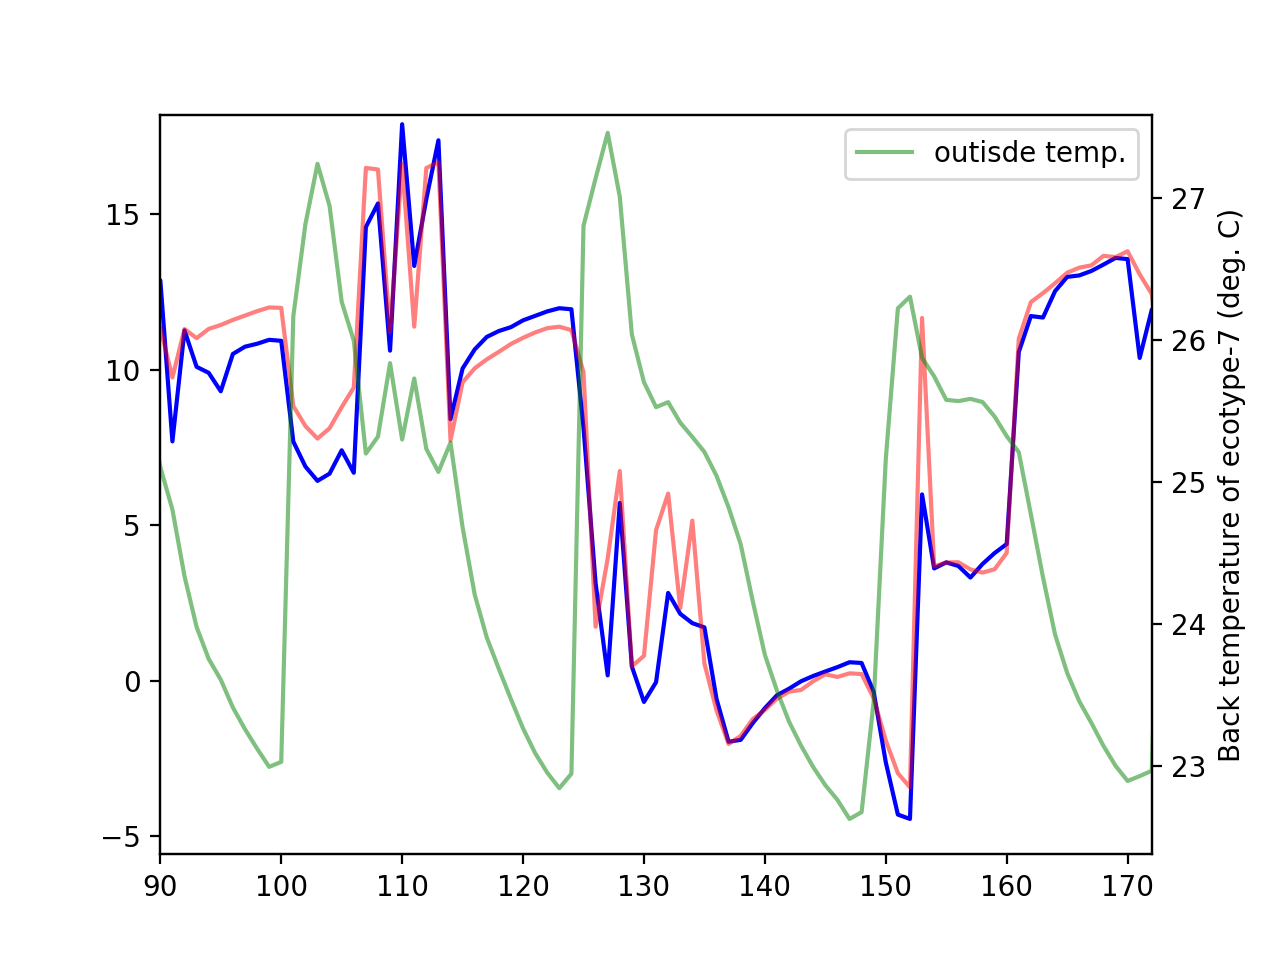

In [133]:
# NETWORK_PATH = 'data/seduceml_2019_07_17_T_14_37_00.h5'
# NETWORK_PATH = 'data/seduceml_2019_07_18_T_15_48_18.h5'
# NETWORK_PATH = 'data/seduceml_2019_07_18_T_15_00_12.h5'
# NETWORK_PATH = 'data/seduceml_2019_07_18_T_16_04_23.h5'
# NETWORK_PATH = 'data/seduceml_2019_07_18_T_16_30_59.h5'
NETWORK_PATH = "last"

start_date = "2019-07-10T00:00:00.000Z"
end_date = "2019-07-24T15:00:00.000Z"
GROUP_BY = 60

COMPARISON_PLOT_DATA = [{'epoch': 200, 'nb_layers': 3, 'neurons_per_layers': 64, 'activation_function': 'relu', 'mse': 3.6156303271737893, 'mse_perc_95': 29.844275604199883, 'rmse': 1.3764298699455324, 'rmse_perc_95': 5.3545053547850285, 'dump_path': 'data/seduceml_2019_07_24_T_13_09_32.h5', 'tmp_figures_folder': 'tmp/2019_07_24__13_08_03', 'scaler_path': 'data/scaler_9c0463ac-6557-4bcf-80db-49c49254cc52'}]

with open("../data.json", "r") as data_file:
    training_data = json.load(data_file)

EPOCHS = list(set([d["epoch"] for d in COMPARISON_PLOT_DATA]))
NB_LAYERS = list(set([d["nb_layers"] for d in COMPARISON_PLOT_DATA]))
NEURONS_PER_LAYER = list(set([d["neurons_per_layers"] for d in COMPARISON_PLOT_DATA]))
ACTIVATION_FUNCTIONS = list(set([d["activation_function"] for d in COMPARISON_PLOT_DATA]))

for PLOT_DATA in COMPARISON_PLOT_DATA:

    if NETWORK_PATH == "last":
        netwok_path = "../data/%s" % (sorted(os.listdir("../data"))[-1])
    else:
        netwok_path = NETWORK_PATH

    oracle = load_model("../"+PLOT_DATA["dump_path"])

    scaler = joblib.load("../"+PLOT_DATA["scaler_path"])

    x, y, tss, data, scaler = generate_real_consumption_data(start_date,
                                                             end_date,
                                                             data_file_path="data_validation.json",
                                                             group_by=GROUP_BY,
                                                             scaler=scaler)

    start_step = 0
    end_step = len(y)

    plot_data = []

    # server_id = 32
    server_id = 6
    
    neighbours = [i for i in range(server_id - 1, 12)]
    neighbours = [server_id - 2, server_id - 1, server_id + 1, server_id + 2, server_id + 3]
    neighbours_weights = [0 if i == server_id else 1 for i in range(0, 12)]
    
    print(neighbours)
    print(neighbours_weights)

    for idx in range(0, len(y)):
        test_input = np.array([x[idx]])
        expected_value = y[idx]
        result = oracle.predict(test_input)[0]

        unscaled_expected_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), expected_value)]))
        unscaled_predicted_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), result)]))

        expected_temp = unscaled_expected_values[:, -len(expected_value):][0]
        predicted_temp = unscaled_predicted_values[:, -len(expected_value):][0]

        mse = ((predicted_temp - expected_temp) ** 2)

        plot_data += [{
            "x": idx,
            "y_actual": expected_value,
            "y_pred": result,
            "temp_room": data.get("room_temperature")[idx],
            "mse_mean": mse.mean(axis=0),
            "mse_raw": mse,
            "rmse_mean": np.sqrt(mse).mean(axis=0),
            "rmse_raw": np.sqrt(mse),
            "temp_actual": expected_temp,
            "temp_pred": predicted_temp,
            "server_power_consumption": unscaled_predicted_values[0][server_id],
            "server_power_consumption_neighbours": np.average(unscaled_predicted_values[0][neighbours], weights=range(0, len(neighbours)))
        }]

    # MSE
    flatten_mse = np.array([d["mse_raw"] for d in plot_data]).flatten()
    mse = flatten_mse.mean()
    mse_perc_95 = flatten_mse[flatten_mse > np.percentile(flatten_mse, 95)].mean()

    # RMSE
    flatten_rmse = np.array([d["rmse_raw"] for d in plot_data]).flatten()
    rmse = flatten_rmse.mean()
    rmse_perc_95 = flatten_rmse[flatten_rmse > np.percentile(flatten_rmse, 95)].mean()

    print("best_mse: %s" % (mse))
    print("best_mse_perc_95: %s" % (mse_perc_95))
    print("best_rmse: %s" % (rmse))
    print("best_rmse_perc_95: %s" % (rmse_perc_95))

    # date_str = time.strftime("%Y_%m_%d_T_%H_%M_%S", time.localtime(epoch))
    # neural_net_dump_path = "data/seduceml_%s.h5" % date_str

    PLOT_DATA["mse"] = mse
    PLOT_DATA["mse_perc_95"] = mse_perc_95
    PLOT_DATA["rmse"] = rmse
    PLOT_DATA["rmse_perc_95"] = rmse_perc_95

    sorted_plot_data = sorted(plot_data, key=lambda d: d["x"])[start_step:end_step]

    fig = plt.figure()
    ax = plt.axes()

    x_data = [d["x"] for d in sorted_plot_data]
    y1_data = [d["temp_actual"][server_id] for d in sorted_plot_data]
    y2_data = [d["temp_pred"][server_id] for d in sorted_plot_data]
    y3_data = [d["temp_room"] for d in sorted_plot_data]
    y4_data = [d["server_power_consumption"] for d in sorted_plot_data]
    y5_data = [d["server_power_consumption_neighbours"] for d in sorted_plot_data]
    x_data = range(0, len(y1_data))
    
    x_np = np.array(x_data[1:])
    y3_np = np.array(y3_data[1:])
    y1_np = np.array(y1_data[1:]) - y3_np
    y2_np = np.array(y2_data[1:]) - y3_np
    y4_np = np.array(y4_data[1:])
    y5_np = np.array(y5_data[1:])

    ax.plot(x_np, y1_np, color='blue', label='actual temp.')
    ax.plot(x_np, y2_np, color='red', label='predicted temp.', alpha=0.5)
    #ax.plot(x_np, y1_np - y2_np, color='red', label='diff temp.', alpha=0.5)
    # ax.plot(x_data, y3_data, color='green', label='room temp.', alpha=0.5)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(x_np, y3_np, color='green', label='outisde temp.', alpha=0.5)
    #ax2.plot(x_np, y4_np, color='green', label='power consumption.', alpha=0.5)
    #ax2.plot(x_np, y5_np, color='orange', label='power consumption. neighbours', alpha=0.5)

    plt.legend()

    plt.xlabel('Time (hour)')
    plt.ylabel('Back temperature of ecotype-%s (deg. C)' % (server_id+1))

    plt.show()

In [115]:
from scipy.optimize import curve_fit
import inspect

def func(X, a, b, c):
    x1, x2 = X
    return a + b * x1 + c * (x2 - x1) * x1
    # return a + b * np.log(c * x)

# cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('hot_r')
nb_args = len(inspect.getargspec(func).args)
p0 = [0 for i in range(1, nb_args)]
popt, pcov = curve_fit(func, (y4_np, y5_np), y1_np, p0)

print(popt)
print(pcov)

#p0 = np.array([23.62261268, -0.13201981, 0.51935314, 0.])

[1.12613170e+00 1.23941826e-01 1.86524727e-05]
[[ 7.61011373e-02 -8.58411900e-04 -1.57975502e-06]
 [-8.58411900e-04  1.38658761e-05  1.19349742e-07]
 [-1.57975502e-06  1.19349742e-07  6.93292300e-09]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


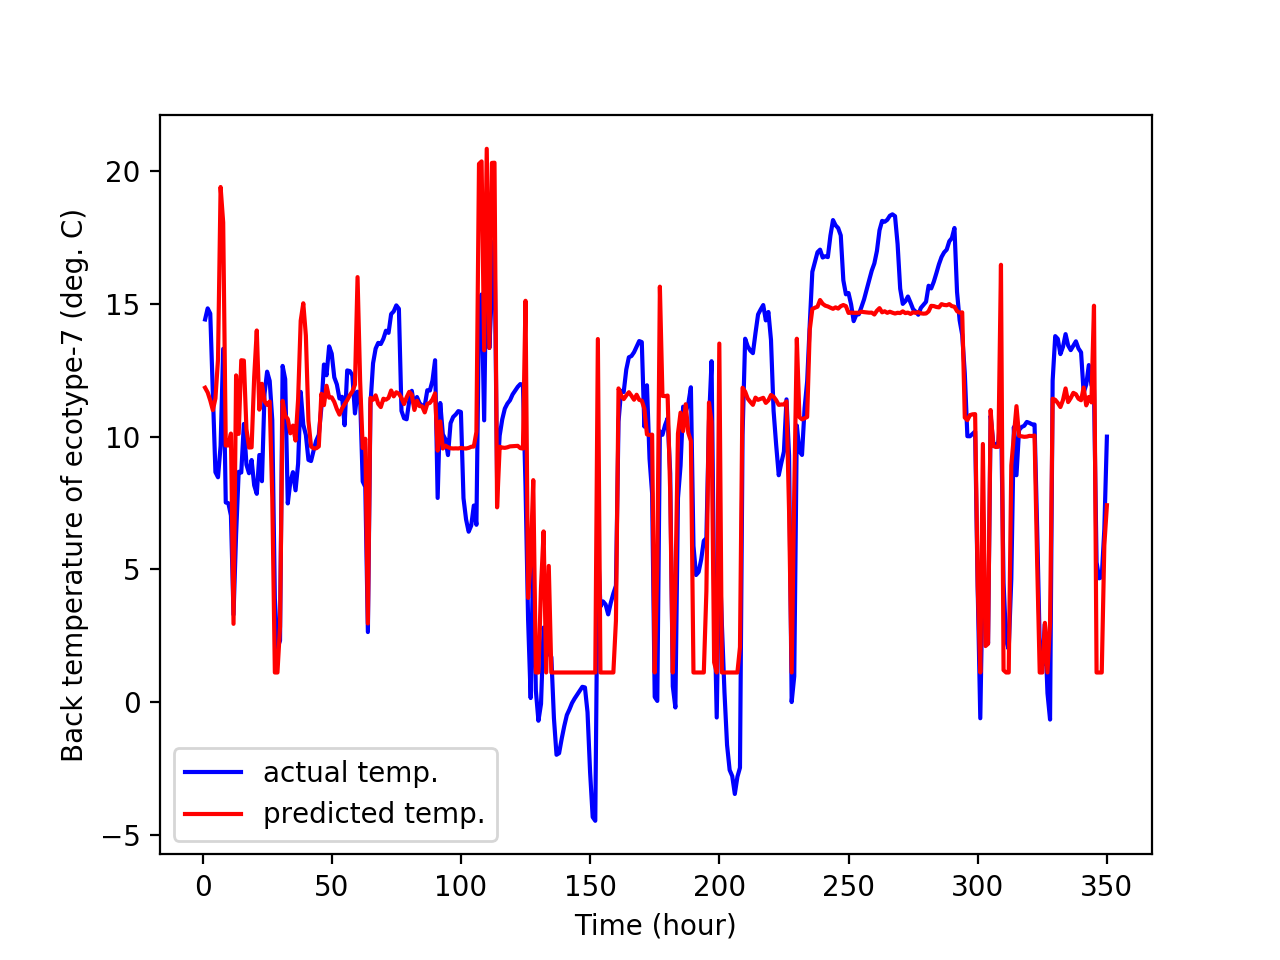

In [117]:
fig = plt.figure()
ax = plt.axes()

x_data = [d["x"] for d in sorted_plot_data]
y1_data = [d["temp_actual"][server_id] for d in sorted_plot_data]

y_pred = [func(y, *popt) for y in zip(y4_np, y5_np)]
y_pred_np = np.array(y_pred)

p1 = ax.plot(x_data[1:], y1_np, color='blue', label='actual temp.')
p2 = ax.plot(x_data[1:], y_pred, color='red', label='predicted temp.')

plt.legend()

plt.xlabel('Time (hour)')
plt.ylabel('Back temperature of ecotype-%s (deg. C)' % (server_id+1))

plt.show()
